In [1]:
import json
import sys
import logging

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from collections import defaultdict

from prettyprinter import pprint
from gcdf1.metrics import get_domain_requests
from gcdf1.utils.data import split_iterator
from gcdf1.utils.utils import (
    count_nested_dict_values,
    default_to_regular,
    nested_defaultdict,
)
from gcdf1.analysis import (
    analyse_simple_context_feature,
    analyse_hierarchical_context_feature,
    analyse_req_expression_patterns
)
from gcdf1.utils.visualisation import plot_stacked_bar
from gcdf1.utils.print import print_dialogue_outline

# Introduction

This notebook shows how to reproduce the results in Section 4 of the [GCDF1: A Goal- and Context- Driven F-Score for Evaluating User
Models](https://aclanthology.org/2021.eancs-1.2.pdf).

## Load data

First, we load the data that we analysed in the paper. The ``../models/convlab_baselines/test`` directory contains the
conversations generated by the agents described in Section 4.1 of the paper, when conditioned
on the MultiWOZ 2.1 dataset test goals.

In [3]:
SPLIT = 'test'  # note that only test set conversations were analysed
BASELINE_PATH_PREFIX = f"../models/convlab_baselines/{SPLIT}"
BASELINE_DATA_PATH = "../models/convlab_baselines"
EVAL_CONFIG_PATH = '../configs/multiwoz_user_evaluator.yaml'

Note that if you generate your own conversations, include them in a subdirectory of ``models`` and augment the
``DATA_PATHS`` and ``EVALUATOR_OUTPUT_NAMES``, then you can easily peform the same analysis on your model.

In [4]:
DATA_PATHS = {
    'baseline': BASELINE_DATA_PATH,
}

EVALUATOR_OUTPUT_NAMES = {
    'baseline': 'baseline.json'
}

The evaluator outputs are stored under the ``['metadata']['rgcd_f1']`` in the output `.json` file.

In [5]:
with open(f"{BASELINE_PATH_PREFIX}/baseline.json", "r") as f:
    baseline_metadata = json.load(f)["metadata"]["rgcd_f1"]

## Analyse repetitions

Let's first see how to analyse situations where the user repeatedly requests the same information. The corresponding
context-driven feature is ``multiple_slot_requests``.

In [6]:
req_repetions_raw = {
    'baseline': baseline_metadata["multiple_slot_requests"]
}

For conveinence, we shorten the names of some of the evaluator fields.

In [7]:
keys_map = {
    'delayed_response': 'delayed_resp',
    'repeated_despite_receiving_answer': 'repeat_after_answer',
    'spurious_annotation': 'noise', 
    'user_prempted_request': 'user_prempts',
    'system_req_nlu_failure': 'nlu_fail'
}

The evaluator tries to ascribe each information request repetition to a behaviour. The behaviours are the keys
on the `req_repetitions_raw['baseline']` dictionary. We can analyse this output using the
`analyse_hierarchical_context_feature` function as shown below. Head over to the `gcdf1.analysis` module for detailed
documentation of this function's output.

In [8]:
keys = ['match_key', 'domain']
req_repeitions_analysed, req_repeitions_counts = {}, {}
for model in req_repetions_raw:
    req_repeitions_analysed[model] = analyse_hierarchical_context_feature(req_repetions_raw[model], keys, new_behaviour_names=keys_map)
    req_repeitions_counts[model] = count_nested_dict_values(req_repeitions_analysed[model])

In [9]:
req_repeitions_counts

{'baseline': {'delayed_resp': {'restaurant': 14,
   'train': 35,
   'attraction': 10,
   'hotel': 5},
  'repeat_after_answer': {'restaurant': 11,
   'attraction': 67,
   'train': 4,
   'hotel': 33},
  'nlu_fail': {'restaurant': 14, 'train': 35, 'attraction': 10, 'hotel': 5}}}

We can use the utilities in `gcdf1.visualisation` to plot a stacked bar chart with our results.

In [10]:
plot_format = {
    'colors': [],
    'stack_order': [],  # must match data dict keys
    'legend': {'fontsize': 'x-large', 'ncol': 2, 'loc': 'upper center'},  # ax.legend API
    'subplot': {'figsize':  (9.77, 5.5)},  # plt.subplot API
    'width': 0.75,
    'ylim': {"bottom": -2, "top": 6.25},
    'xlim': {"left": 0, "right": 90},

    "xlabel": {"xlabel": "# dialogues", "size": "xx-large"},
    "ylabel": {"ylabel": "Domain", "size": "xx-large"},
    'tick_params':{
    'x': {'labelsize': 'xx-large'},  # ax.tick_params  API
    'y': {'labelsize': 'xx-large'}
    },

    'orientation': 'horizontal',
    'title': {'label':""}
}

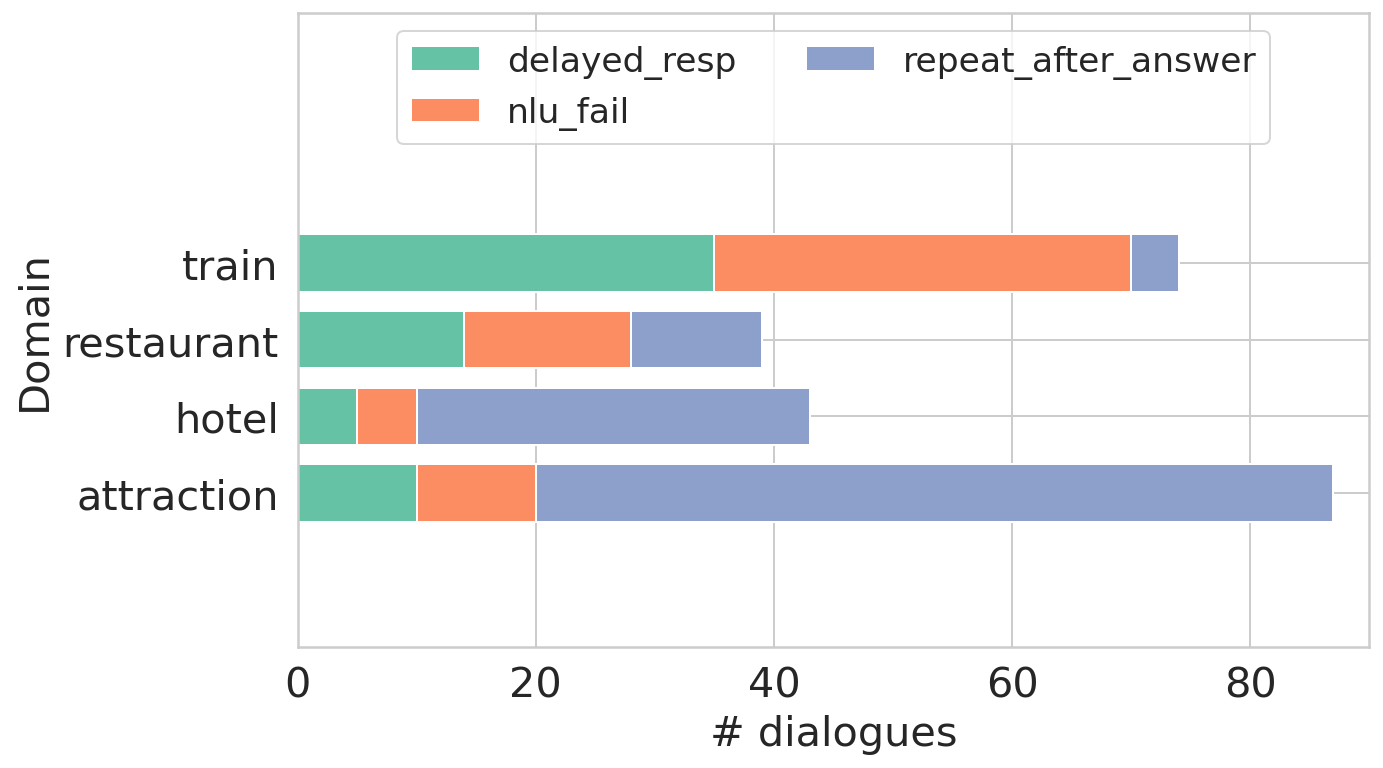

In [11]:
model = 'baseline'
data = req_repeitions_counts[model]
plot_format['colors'] = sns.color_palette("Set2", n_colors=len(data.keys()))
plot_format['stack_order'] = sorted(list(data.keys()))
ax, fig = plot_stacked_bar(
    data, plot_format
)
plt.tight_layout()

Suppose we want to conduct a fine-grained analysis of the model output. We can use the analysis functions to extract
the dialogue IDs where certain behaviours are matched.

In [12]:
keys = ['match_key', 'domain', "slot"]
req_rep_slot_level_dials, req_rep_slot_level = {}, {}
for model in req_repetions_raw:
    req_rep_slot_level_dials[model] = analyse_hierarchical_context_feature(req_repetions_raw[model], keys, new_behaviour_names=keys_map, store_dial_id=True)
    req_rep_slot_level[model] = analyse_hierarchical_context_feature(req_repetions_raw[model], keys, new_behaviour_names=keys_map, store_dial_id=False)

In [13]:
req_rep_slot_level_dials['baseline'].keys()

dict_keys(['delayed_resp', 'repeat_after_answer', 'nlu_fail'])

We can retrieve the dialogues where the baseline models failed due to an NLU error
related to the `hotel-stars` slot as follows.

In [14]:
req_rep_slot_level_dials[model].keys()

dict_keys(['delayed_resp', 'repeat_after_answer', 'nlu_fail'])

In [15]:
model = 'baseline'
reason = 'nlu_fail'
domain = 'hotel'

In [16]:
req_rep_slot_level_dials[model][reason][domain].keys()

dict_keys(['hotel-type', 'hotel-internet', 'hotel-pricerange'])

In [17]:
slot = 'hotel-pricerange'
dialogues = req_rep_slot_level_dials[model][reason][domain][slot]

The `print_dialogue_outline` utility can be used in conjuction with the split iterators to
retrieve the specific conversations.

``NOTE``: Do not use the `return_only` kwarg for MultWOZ as the implementation does not use an index
of the conversations and is slow. Use the `continue` statement as shown below.

In [18]:
for _, dial in split_iterator(
    "test",
    data_pckg_or_path=DATA_PATHS[model],
):
    dial_id = dial['dialogue_id']
    if dial_id not in dialogues:
        continue    
    print()
    print()
    print(pprint(dial["goal"]))
    print()
    print_dialogue_outline(dial, text=True)



{
    'hotel': {
        'info': {
            'area': 'north',
            'parking': 'yes',
            'stars': '0',
            'type': 'guesthouse'
        },
        'reqt': {
            'address': '?',
            'internet': '?',
            'pricerange': '?'
        }
    }
}
None

Turn: 0:USER I ' m looking for a hotel . I would like it to be a 0 star hotel . I would prefer the hotel be in the north . Oh , i need parking.
hotel-inform<<<stars===0
hotel-inform<<<area===north
hotel-inform<<<parking===yes

###############  NLU  ###############

Turn: 1:SYSTEM It is rated 0 stars , is that okay ? There is wifi available at the hotel . The parking is free . How about city centre north b and b ?
hotel-inform<<<stars===0
hotel-inform<<<internet===yes
hotel-inform<<<parking===yes
hotel-inform<<<name===city centre north b and b

###############  NLU  ###############
hotel-inform<<<parking===yes
hotel-inform<<<stars===0
hotel-inform<<<area===north


Turn: 2:USER It should be a guest

## Analyse the constraint expression patterns

A user has the choice to request multiple pieces of information at once or across
multiple turns. Below, we check how often the information is requested at once.

In [19]:
domains = ['hotel', 'restaurant', 'attraction', 'taxi', 'train']
split = 'test'

Let's first see in how many dialogues the user has to request more than one piece of information.

In [20]:
multiple_req_dial_counts =  defaultdict(list)
for _, dial in split_iterator(
    split,
    data_pckg_or_path=BASELINE_DATA_PATH,
    ):

    dial_id = dial['dialogue_id']
    for domain in domains:
        goal_reqs = get_domain_requests(dial['goal'], domain)
        if not goal_reqs:
            continue

        if len(goal_reqs) > 1:
            multiple_req_dial_counts[domain].append(dial_id)

In [21]:
total_mul_req_dialogues = count_nested_dict_values(multiple_req_dial_counts)

In [22]:
total_mul_req_dialogues

defaultdict(list,
            {'train': 149,
             'taxi': 195,
             'restaurant': 106,
             'attraction': 248,
             'hotel': 115})

We can now use the utilities provided to analyse the user behaviour.

In [23]:
BASELINE_DATA_PATH

'../models/convlab_baselines'

In [24]:
expression_patterns = {
    'baseline': analyse_req_expression_patterns(
        split,
        domains,
        BASELINE_DATA_PATH,
        EVAL_CONFIG_PATH
    )
}

In [25]:
expression_patterns_count = {}
for model in expression_patterns:
    expression_patterns_count[model] = count_nested_dict_values(expression_patterns[model])

In [26]:
expression_patterns_perc = nested_defaultdict(float, depth=3)
for model in expression_patterns_count:
    for domain in total_mul_req_dialogues:
        div = total_mul_req_dialogues[domain]
        constr_type_counts = expression_patterns_count[model][domain]
        for category in constr_type_counts:
            try:
                counts = expression_patterns_count[model][domain][category]
            except KeyError:
                counts = 0.0
            expression_patterns_perc[model][category][domain] = round( 100*counts/ div ,2)

In [27]:
plot_format = {
    'colors': [],
    'stack_order': [],  # must match data dict keys
    'legend': {'fontsize': 'small', 'ncol': 2, 'loc': 'upper center'},  # ax.legend API
    'subplot': {'figsize': (8.885, 5)},  # plt.subplot API
    'width': 1,
    'ylim': {"bottom": -2, "top": 10},
    'xlim': {"left": 0, "right": 100.1},

    "xlabel": {"xlabel": "Percentage", "size": "medium"},
    "ylabel": {"ylabel": "Domain", "size": "medium"},
    'ticks': {'x': {'vals':list(range(0, 110, 5))}},
    'tick_params':{
        'x': {'labelsize': 'medium'},  # ax.tick_params  API
        'y': {'labelsize': 'medium'}
    },
    
    'orientation': 'horizontal',
    'scale': {'y': 2}
}

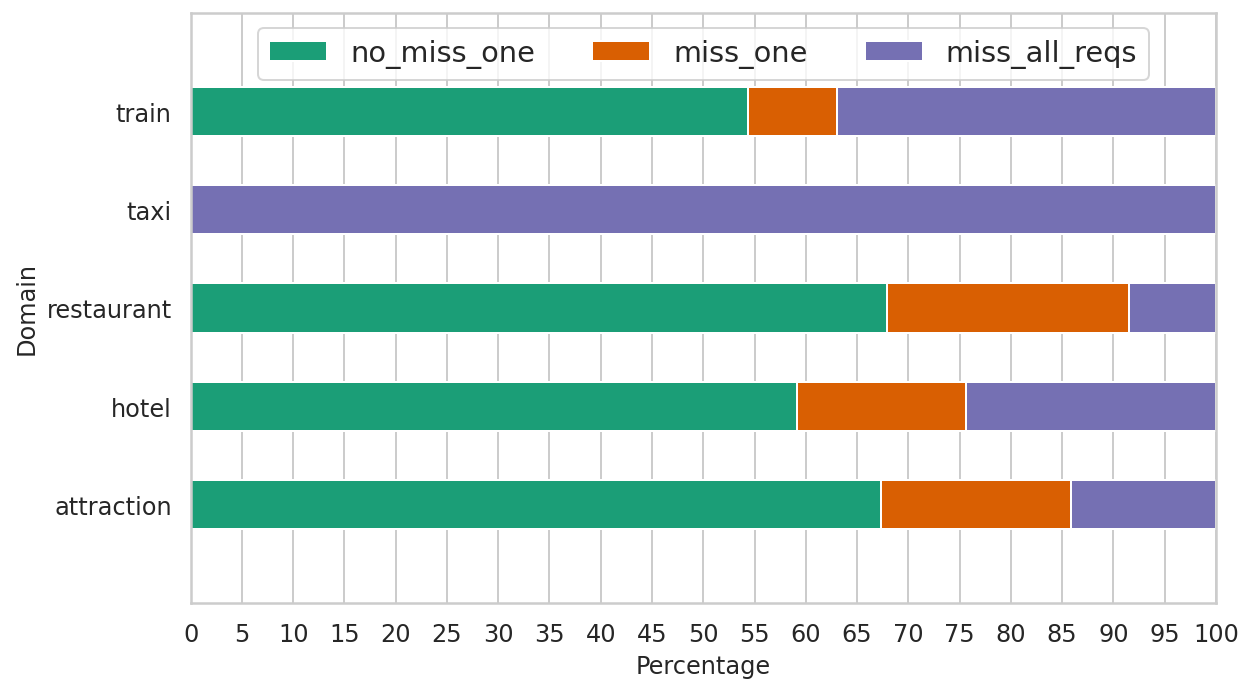

In [28]:
model = 'baseline'
data = expression_patterns_perc[model]
plot_format['legend'] = {'fontsize': 'large', 'ncol': 3, 'loc': 'upper center'}  # ax.legend API
plot_format['colors'] = sns.color_palette("Dark2", n_colors=len(data.keys()))
plot_format['stack_order'] = sorted(list(data.keys()), reverse=True)
plot_format['xlim'] = {"left": 0, "right": 100}
ax, fig = plot_stacked_bar(
    data, plot_format
)
plt.tight_layout()

The plot above shows that the user never requests information across multiple turns, suggesting the its behaviour
diversity can be improved.

This behaviour could, nonetheless, be determined by the system, which can choose to provide
all the information about an entity at once. Below, we analyse what percentage of the requests that have
not been made by the user are provided by the system before the user can request them. This information is stored in
the `provision_entire_domain` and `provision_slots` fields of the evaluator output.
#%

In [29]:
provision_data = {
    'baseline': {
        'prov_all': baseline_metadata['provision_entire_domain'],
        'prov_some': baseline_metadata['provision_slots']
    }
}

In [30]:
sys_provision_dials = nested_defaultdict(list, depth=3)
for model in provision_data:
    prov_data = provision_data[model]
    for _, dial in split_iterator(
        split,
        data_pckg_or_path=DATA_PATHS[model],
        ):

        dial_id = dial['dialogue_id']
        for domain in domains:
            goal_reqs = get_domain_requests(dial['goal'], domain)
            if not goal_reqs:
                continue
            if len(goal_reqs) == 1:
                continue
            for key in sorted(list(prov_data.keys())):
                if dial_id in prov_data[key] and domain in prov_data[key][dial_id]:
                    break
            else:
                key = 'no_prov'
            sys_provision_dials[model][key][domain].append(dial_id)

sys_provision_counts = count_nested_dict_values(default_to_regular(sys_provision_dials))

In [31]:
sys_provision_perc = nested_defaultdict(float, depth=3)
for model in sys_provision_counts:
    for domain in total_mul_req_dialogues:
        div = total_mul_req_dialogues[domain]
        constr_type_counts = sys_provision_counts[model]
        for category in constr_type_counts:
            try:
                counts = sys_provision_counts[model][category][domain]
            except KeyError:
                counts = 0.0
            sys_provision_perc[model][category][domain] = round( 100*counts/ div ,2)

In [32]:
plot_format['ylim'] = {"bottom": -2, "top":10}

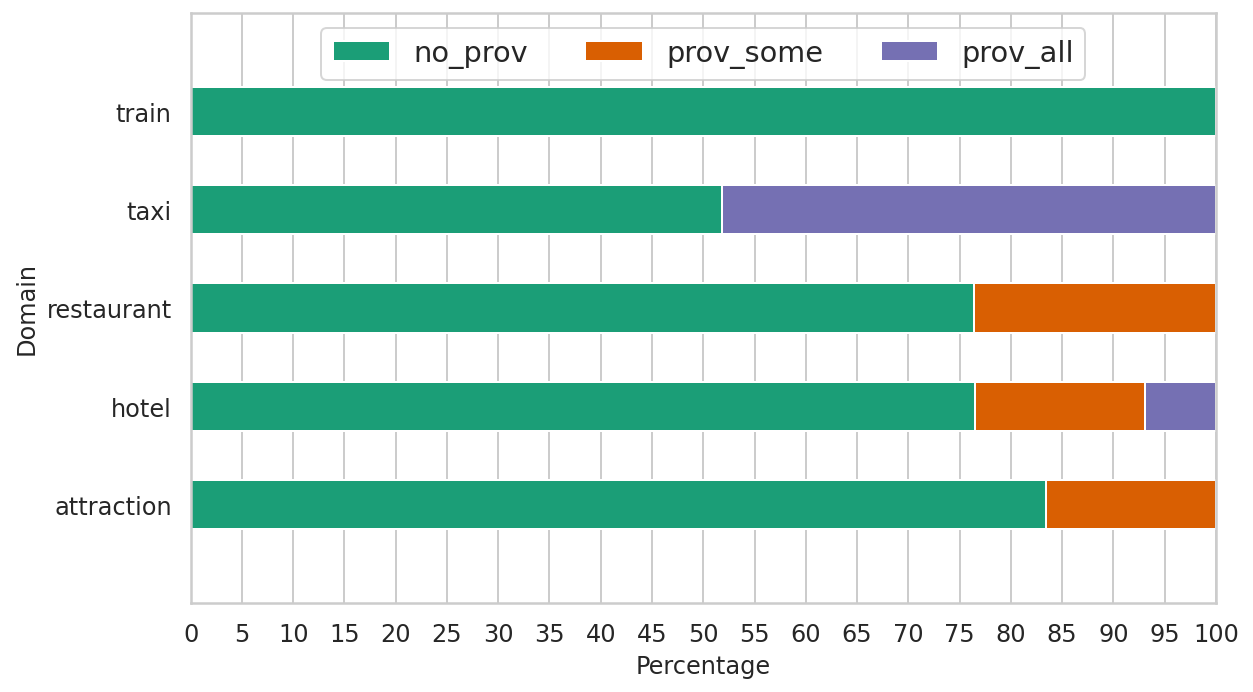

In [33]:
model = 'baseline'
data = sys_provision_perc[model]
plot_format['colors'] = sns.color_palette("Dark2", n_colors=len(data.keys()))
plot_format['stack_order'] = ['no_prov', 'prov_some', 'prov_all']
ax, fig = plot_stacked_bar(
    data, plot_format
)
plt.tight_layout()
